In [1]:
# const USE_GPU = true  # Use GPU? If this is set false, then no GPU needs to be available
# const NDIMS = 3
using Revise
# using ParallelStencil
# using ParallelStencil.FiniteDifferences3D
using GeoPhyInv
import GeoPhyInv.Data
import GeoPhyInv.FiniteDifferences3D
using ProgressMeter
using Distributed
using DistributedArrays
using CUDA
using NamedArrays
using OrderedCollections


using Plots, Printf, Statistics

GeoPhyInv.@init_parallel_stencil(CUDA, Float64, 3)
#     @init_parallel_stencil(Threads, Float64, 3)
plotly()
gr()


┌ Info: Precompiling GeoPhyInv [e0ed03db-c84c-5109-9210-aed666ad9ba8]
└ @ Base loading.jl:1317


Any[1, :iy, :ix]Any[2, :iy, :ix]Any[3, :iy, :ix]iyixvzvxvyAny[:(n + 1), :iy, :ix]
Any[:iz, 1, :ix]Any[:iz, 2, :ix]Any[:iz, 3, :ix]izixvyvxvzAny[:iz, :(n + 1), :ix]
Any[:iz, :iy, 1]Any[:iz, :iy, 2]Any[:iz, :iy, 3]iziyvxvyvzAny[:iz, :iy, :(n + 1)]


┌ Warning: Module Data from previous module initialization found in caller module (Main); module Data not created. If you are working interactively in the REPL, then you can ignore this message.
└ @ ParallelStencil.ParallelKernel /home/pawan/.julia/packages/ParallelStencil/0VULM/src/ParallelKernel/init_parallel_kernel.jl:33
┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/pawan/.julia/packages/Plots/HcxwM/src/backends.jl:435


Plots.GRBackend()

In [2]:
# medium=Medium(:marmousi2)


# mgrid_new=[range(-1000, stop=5000, length=255), range(-1000,20000,length=1000)];
# mediumup=update(medium,mgrid_new)

# mediumup=GeoPhyInv.padarray(medium, 400)
# heatmap(mediumup,:vs)


In [19]:
mgrid=fill(range(-1000, stop=1000, length=215), 3);
nx,ny,nz=length.(mgrid);
dx,dy,dz=step.(mgrid);
medium=Medium(mgrid,[:vp,:rho,:vs])
vpb = [3000., 3500.] # bounds for vp
vsb = [1900, 2000] # bounds for vs
rhob = [1., 2.] # density bounds
GeoPhyInv.update!(medium, [:vp,:vs,:rho], [vpb,vsb,rhob]);
fill!(medium);
# GeoPhyInv.update!(medium, [:vp,:vs,:rho], randn_perc=5); # add some random noise
# medium

medium.bounds[:vs]

2-element Vector{Float64}:
 1900.0
 2000.0

In [20]:

ageom=AGeom(medium.mgrid, SSrcs(1), [Srcs(1)], [Recs(10)])
fill!.(ageom[1].s,0.0)

3-element Named Vector{Vector{Float64}}
A  │ 
───┼──────
:z │ [0.0]
:y │ [0.0]
:x │ [0.0]

nt:	1630

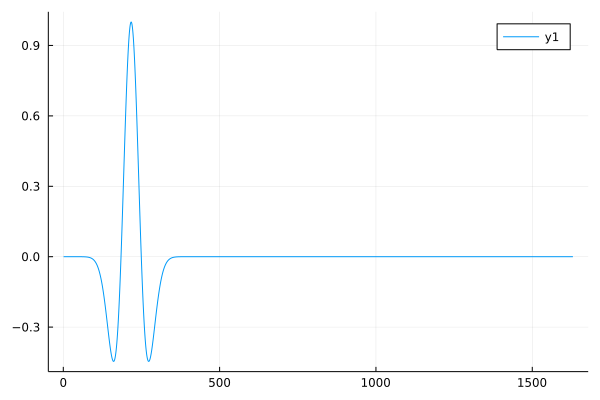

In [21]:
wav, tgrid=ricker(medium, 4, 1, 0.4)
dt=step(tgrid)

tmax=maximum(tgrid); nt=length(tgrid); 
print("nt:\t",length(tgrid))


freqmax=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:max)
freqpeak=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:peak)
freqmin=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:min)


srcwav = SrcWav(tgrid, ageom, [:tauyy])
GeoPhyInv.update!(srcwav, [:tauyy], wav)

plot(wav)

In [22]:
CUDA.reclaim()
pa = SeisForwExpt(
    FdtdElastic(),
    npw = 1,
    medium = medium,
    ageom = [ageom],
    srcwav = [srcwav],
    sflags = [2],
    rflags = [1],
    tgrid = tgrid,
    verbose = true,
);


┌ Info: spatial sampling (9.35e+00) can be as high as 2.01e+01
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:36
┌ Info: time sampling (1.07e-03) can be as high as 1.16e-03
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:51


[255, 255, 255]
[255, 255, 255]


In [23]:

ENV["GKSwstype"] = "nul";
if (isdir("viz3D_out") == false)
    mkdir("viz3D_out")
else
    foreach(rm, filter(endswith(".png"), readdir("./viz3D_out", join = true)))
end;
loadpath = "./viz3D_out/";
anim1 = Animation(loadpath, String["slice y"])
nout=div(nt,100)
println("Animation directory: $(anim1.dir)")
GeoPhyInv.initialize!(localpart(pa.p))
@showprogress for it = 1:nt
    GeoPhyInv.advance!(pa.c, localpart(pa.p))
    # Visualisation

	GeoPhyInv.add_source!(it, 1, 1, pa.c, localpart(pa.p), GeoPhyInv.Source_B1())

    if mod(it, nout) == 0
        heatmap(
            Array(localpart(pa.p)[1].w1[:t][:vy])[1:end, 1:end, div(nx,2)],
            aspect_ratio = 1,
            # xlims = (1, nx + 1),
            # ylims = (1, nz),
            c = :viridis,
            title = "vx",
            clims = (-0.75, 0.75),
        )
        frame(anim1)
    end

end


Animation directory: ./viz3D_out/


Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


┌ Info: Saved animation to 
│   fn = /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif
└ @ Plots /home/pawan/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif")
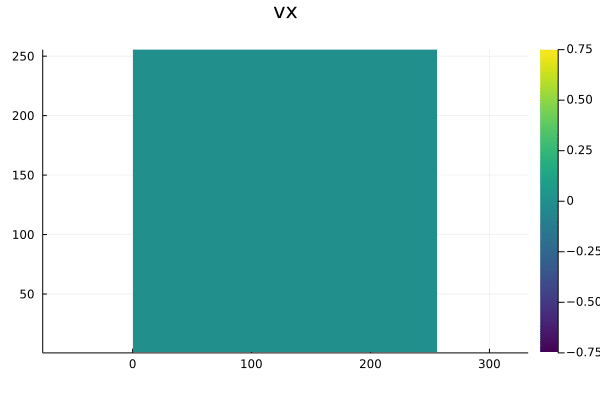

In [24]:
gif(anim1, "acoustic3D.gif", fps=15)


┌ Info: Saved animation to 
│   fn = /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif
└ @ Plots /home/pawan/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif")
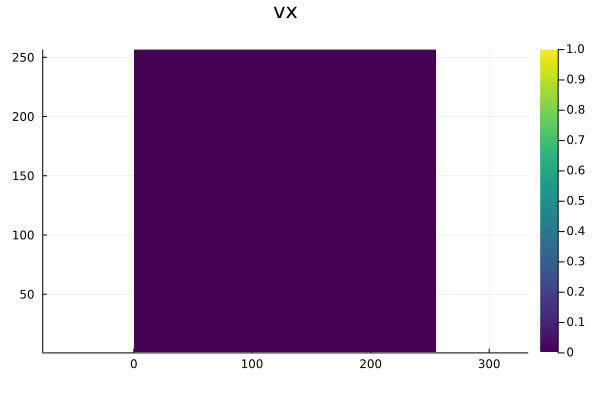

In [24]:
gif(anim1, "acoustic3D.gif", fps=15)

In [16]:
size(localpart(pa.p)[1].w1[:t][:dpdz])
# typeof(pa.c.mod[:M])

(1, 1, 1)

In [25]:
pa.c.pml[:x][:a]

255-element CuArray{Float64, 1}:
 -0.20257118139611882
 -0.1815815385686181
 -0.1613830458002813
 -0.1420571103872708
 -0.12368280792875068
 -0.10633633411610974
 -0.09009046796662626
 -0.07501405180565053
 -0.06117149321744354
 -0.04862229403352526
 -0.03742061120975294
 -0.027614854161362362
 -0.019247322781972737
  ⋮
 -0.027614854161362258
 -0.037420611209753186
 -0.04862229403352537
 -0.06117149321744332
 -0.07501405180565088
 -0.09009046796662626
 -0.10633633411611035
 -0.12368280792875105
 -0.1420571103872708
 -0.16138304580028184
 -0.18158153856861844
 -0.2025711813961187

In [7]:

GeoPhyInv.check_fd_stability(medium.bounds, mgrid, tgrid, freqmin, freqmax, true, 10, 0.5)

┌ Info: spatial sampling (3.94e+00) can be as high as 5.01e+00
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:36
┌ Info: time sampling (4.50e-04) can be as high as 4.88e-04
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:51
